In [12]:
# Install necessary packages
install.packages("dplyr")
install.packages("ggplot2")
install.packages("readr")
install.packages("tidyr")  # For pivot_wider()

# Load libraries
library(dplyr)
library(ggplot2)
library(readr)
library(tidyr)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [13]:
# Step 1: Load the data
case_data <- read.table("PC_case.txt", header = FALSE, sep = "\t", stringsAsFactors = FALSE)
control_data <- read.table("PC_control.txt", header = FALSE, sep = "\t", stringsAsFactors = FALSE)
gene_data <- read.table("geneList.txt", header = FALSE, sep = "\t", stringsAsFactors = FALSE)

# Assign column names
colnames(case_data) <- c("chromosome", "start", "end", "variation", "patient_id")
colnames(control_data) <- c("chromosome", "start", "end", "variation", "patient_id")
colnames(gene_data) <- c("gene_id", "placeholder", "chromosome", "gene_start", "gene_end",
                         "extra1", "extra2", "extra3", "extra4", "extra5", "extra6", "extra7", "extra8")

# Filter relevant columns from gene_data
gene_data <- gene_data %>%
  select(gene_id, chromosome, gene_start, gene_end)

In [14]:
# Step 2: Data Preprocessing
# Remove duplicates and ensure data consistency
case_filtered <- case_data %>%
  distinct(chromosome, start, end, variation)

control_filtered <- control_data %>%
  distinct(chromosome, start, end, variation)

# Identify unique CNV regions in the case dataset
unique_case <- anti_join(case_filtered, control_filtered, by = c("chromosome", "start", "end", "variation"))


In [15]:
# Step 3: Analyze Data
# Identify overlapping genes within unique CNV regions
genes_in_regions <- gene_data %>%
  filter(chromosome %in% unique_case$chromosome) %>%
  rowwise() %>%
  filter(any(unique_case$start <= gene_end & unique_case$end >= gene_start))

# Save the list of disease-related genes
write.csv(genes_in_regions, "genes_associated_with_cnv.csv", row.names = FALSE)

# Perform basic statistics
cnv_stats <- unique_case %>%
  group_by(chromosome, variation) %>%
  summarize(count = n(), .groups = "drop")

# Save CNV statistics
write.csv(cnv_stats, "cnv_statistics.csv", row.names = FALSE)


[1] "Saved cnv_distribution_case.png"


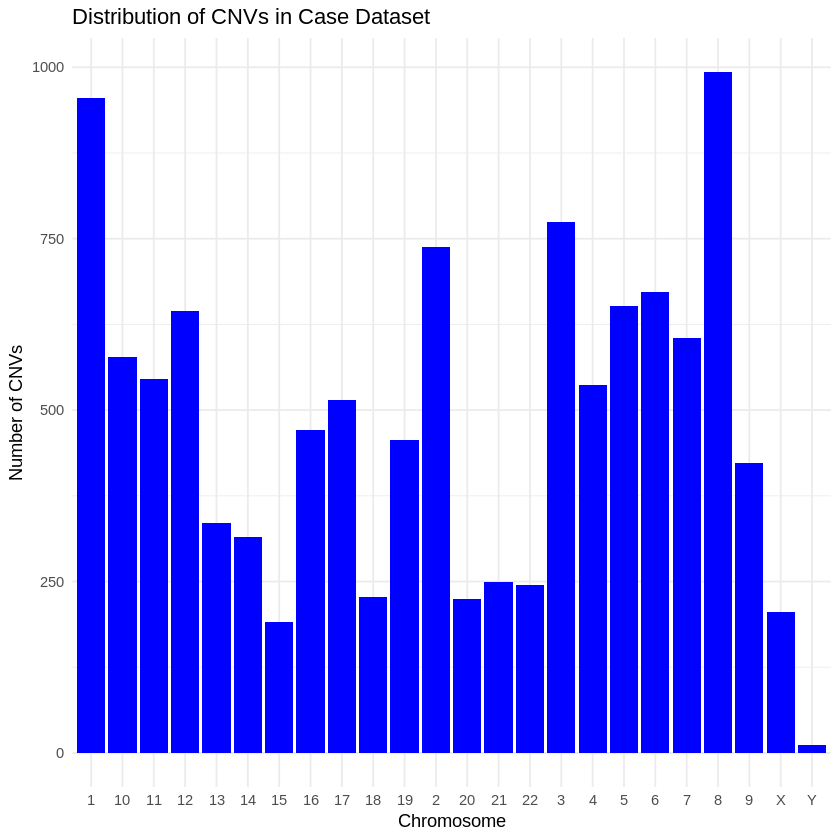

[1] "Saved cnv_type_distribution.png"


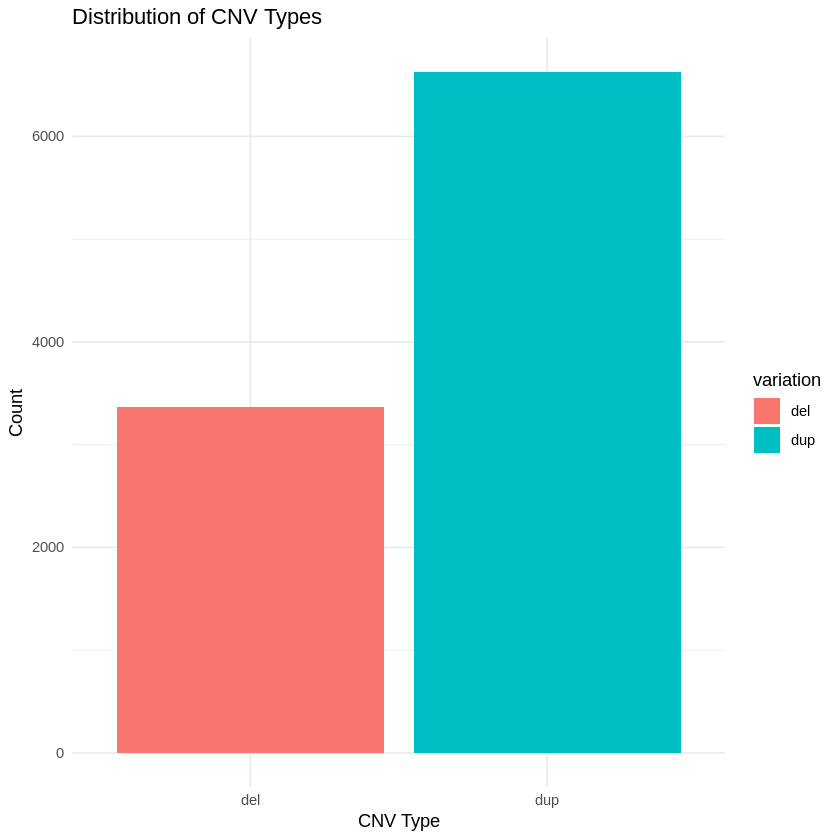

[1] "Saved cnv_heatmap_data.csv"


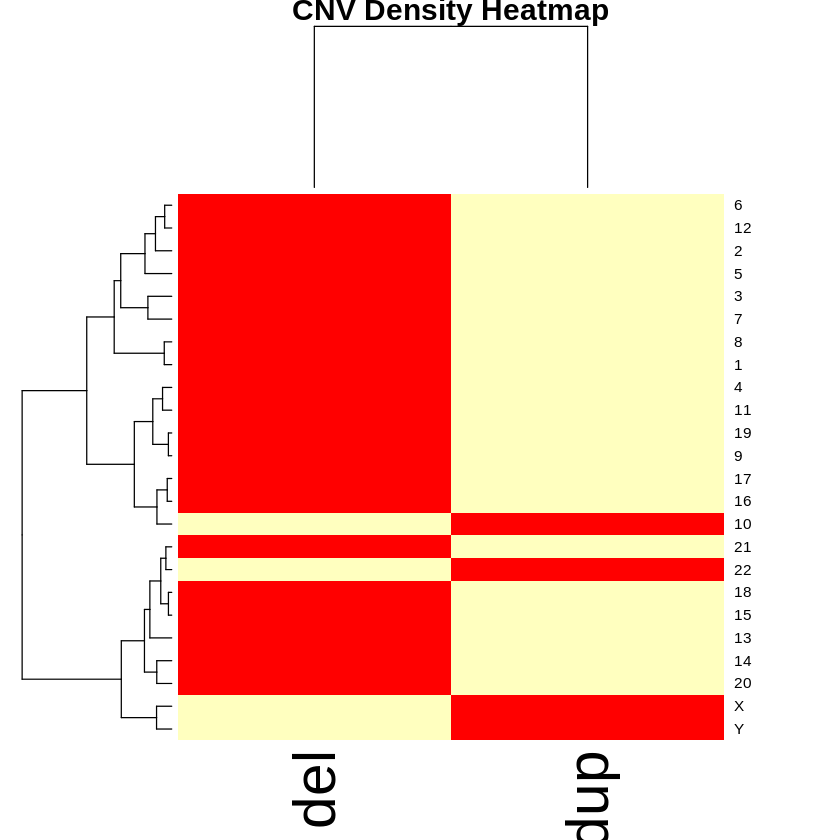

In [19]:
# Step 4: Visualization

# Plot 1: Distribution of CNVs across chromosomes
cnv_distribution_plot <- ggplot(case_data, aes(x = chromosome)) +
  geom_bar(fill = "blue") +
  theme_minimal() +
  labs(title = "Distribution of CNVs in Case Dataset", x = "Chromosome", y = "Number of CNVs")

# Display the plot to confirm it renders
print(cnv_distribution_plot)

# Save the plot
ggsave("cnv_distribution_case.png", plot = cnv_distribution_plot, width = 7, height = 7)
print("Saved cnv_distribution_case.png")

# Plot 2: Distribution of CNV types
cnv_type_plot <- ggplot(unique_case, aes(x = variation, fill = variation)) +
  geom_bar() +
  theme_minimal() +
  labs(title = "Distribution of CNV Types", x = "CNV Type", y = "Count")

# Display the plot to confirm it renders
print(cnv_type_plot)

# Save the plot
ggsave("cnv_type_distribution.png", plot = cnv_type_plot, width = 7, height = 7)
print("Saved cnv_type_distribution.png")

# Heatmap for CNV density across chromosomes
heatmap_data <- unique_case %>%
  group_by(chromosome, variation) %>%
  summarize(cnv_count = n(), .groups = "drop") %>%
  pivot_wider(names_from = variation, values_from = cnv_count, values_fill = 0)

heatmap_matrix <- as.matrix(heatmap_data[, -1])
rownames(heatmap_matrix) <- heatmap_data$chromosome

# Create the heatmap
heatmap(heatmap_matrix, main = "CNV Density Heatmap", col = heat.colors(10))

# Save heatmap data
write.csv(heatmap_data, "cnv_heatmap_data.csv", row.names = TRUE)
print("Saved cnv_heatmap_data.csv")


In [20]:
# Step 5: Final Output
# Save unique CNV regions to a CSV file
write.csv(unique_case, "unique_cnv_regions.csv", row.names = FALSE)

# Generate a summary report
summary_report <- list(
  "CNV Statistics" = cnv_stats,
  "Number of Unique CNV Regions" = nrow(unique_case),
  "Number of Associated Genes" = nrow(genes_in_regions)
)

summary_report_file <- "summary_report.txt"
cat("Summary Report\n", file = summary_report_file)
cat("---------------\n", file = summary_report_file, append = TRUE)
cat(paste("Number of Unique CNV Regions:", nrow(unique_case)), "\n", file = summary_report_file, append = TRUE)
cat(paste("Number of Associated Genes:", nrow(genes_in_regions)), "\n", file = summary_report_file, append = TRUE)
cat("\nCNV Statistics:\n", file = summary_report_file, append = TRUE)
write.table(cnv_stats, file = summary_report_file, append = TRUE, col.names = TRUE, row.names = FALSE)

# Print completion message
print("Analysis and visualization complete. Outputs saved.")

Warning message in write.table(cnv_stats, file = summary_report_file, append = TRUE, :
“appending column names to file”


[1] "Analysis and visualization complete. Outputs saved."
